In [3]:
# imports
import pathlib
import os
import pandas as pd
import cobra
from cobra.flux_analysis import flux_variability_analysis

In [4]:
# get data & model folders
current_dir = pathlib.Path(os.getcwd())
model_dir = current_dir.parent / "models"

In [5]:
# save model names
models = {
    "ihuman": "Human-GEM.xml",
    "A375_ftINIT_10": "A375_ftINIT_model.xml",
    "A375_ftINIT_11": "A375_ftINIT_1+1_model.xml",
    "A375_sMOMENT": "A375_sMOMENT_model.xml"
}


In [6]:
fva_solutions = {}
for model_name, model_path in models.items():
    with cobra.io.read_sbml_model(model_dir / model_path) as model:
        df_fva = flux_variability_analysis(model, fraction_of_optimum=0.95)
        df_fva.to_csv(f"FVA_solution_{model_name}.tsv", sep="\t")
        fva_solutions[model_name] = df_fva


In [149]:
for model_name, model_path in models.items():
    df_fva = pd.read_csv(f"FVA_solution_{model_name}.tsv", delimiter="\t", index_col=0)
    fva_solutions[model_name] = df_fva

In [150]:
# the sMOMENT model includes several helper reactions that should not be counted in for metabolic flux
# Reactions that need to be left out include:
# - ENZYME_DELIVERY_<gene_id> (exchange reaction for input of measured enzyme constraints)
# - ER_pool_TG_ (exchange reaction for input of total enzyme pool constrain for all reactions)
#
# Additionally, reversible reaction fluxes have to be combined:
# - <reaction_id>_TG_forward & <reaction_id>_TG_rv
#
# lastly, isoenzyme reactions are split in the following schema:
# armr_<reaction_id> (exchange reaction for getting rid of a pseudometabolite)
# <reaction_id>_GPRSPLIT_1 (reaction including isoenzyme 1 and producing the pseudometabolite)
# <reaction_id>_GPRSPLIT_2 (reaction including isoenzyme 1 and producing the pseudometabolite)
# <reaction_id>_GPRSPLIT_3 (reaction including isoenzyme 1 and producing the pseudometabolite)
# ...
# the flux range for the arm reaction already includes the flux range for the reaction, 
# so the split reactions are not needed (except if there is no arm reaction for a split reaction)

ftINIT_react = fva_solutions["A375_ftINIT_10"].index  # reactions in the model the sMOMENT model was created from
df_sM = fva_solutions["A375_sMOMENT"] # reactions & fluxes of the sMOMENT model
df_mapped = pd.DataFrame(index=ftINIT_react, columns=["minimum", "maximum"])

for reaction in df_sM.index:
    # irreversible non-isoenzyme reaction
    if reaction in ftINIT_react:
        df_mapped.loc[reaction, ["minimum", "maximum"]] = df_sM.loc[reaction, ["minimum", "maximum"]]

    # reversible non-isoenzyme reactions
    # arm reactions, even if reversible, lack the _TG identifier and are thus not included
    elif reaction.endswith("_TG_forward") and not "_GPRSPLIT" in reaction:
        reaction_id = reaction.replace("_TG_forward", "")
        df_mapped.loc[reaction_id, "maximum"] = df_sM.loc[reaction, "maximum"]
        df_mapped.loc[reaction_id, "minimum"] = (df_sM.loc[reaction.replace("forward", "reverse"), "maximum"]) * (-1)

    # isoenzyme reactions 
    # the flux range is the same for the reactions with each isoenzyme, so only the value of the first one is used
    elif "_GPRSPLIT_1" in reaction:
        reaction_id_rev = reaction.replace("_GPRSPLIT_1", "") 

        # reversible isoenzyme reactions 
        if reaction_id_rev.endswith("_forward"):
            reaction_id = reaction_id_rev.replace("_TG_forward", "")
            df_mapped.loc[reaction_id, "maximum"] = df_sM.loc[reaction, "maximum"]
            df_mapped.loc[reaction_id, "minimum"] = (df_sM.loc[reaction.replace("forward", "reverse"), "maximum"]) * (-1)

        # irreversible isoenzyme reactions
        elif not reaction_id_rev.endswith("_reverse"):
            df_mapped.loc[reaction_id_rev, ["minimum", "maximum"]] = df_sM.loc[reaction, ["minimum", "maximum"]]




In [153]:
for model_name, df in fva_solutions.items():
    df["variability"] = df["maximum"] - df["minimum"]
    print(model_name)
    print(df)

ihuman
          minimum  maximum  variability
MAR03905      0.0   1000.0       1000.0
MAR03907      0.0   1000.0       1000.0
MAR04097      0.0    175.0        175.0
MAR04099      0.0    175.0        175.0
MAR04108      0.0    175.0        175.0
...           ...      ...          ...
MAR20179      0.0      0.0          0.0
MAR20180      0.0      0.0          0.0
MAR20181  -1000.0   1000.0       2000.0
MAR20182  -1000.0   1000.0       2000.0
MAR20183  -1000.0   1000.0       2000.0

[12971 rows x 3 columns]
A375_ftINIT_10
          minimum  maximum  variability
MAR03905      0.0   1000.0       1000.0
MAR03907      0.0   1000.0       1000.0
MAR04097      0.0    175.0        175.0
MAR04099      0.0    175.0        175.0
MAR04108      0.0    175.0        175.0
...           ...      ...          ...
MAR20177      0.0   1000.0       1000.0
MAR20178      0.0   1000.0       1000.0
MAR20181  -1000.0   1000.0       2000.0
MAR20182  -1000.0   1000.0       2000.0
MAR20183  -1000.0   1000.0      

In [156]:
import matplotlib.pyplot as plt
import numpy as np

C:\Users\phili\AppData\Local\Temp\ipykernel_12364\770849720.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["variability"] for df in fva_solutions.values()], labels=[name for name in fva_solutions.keys()])


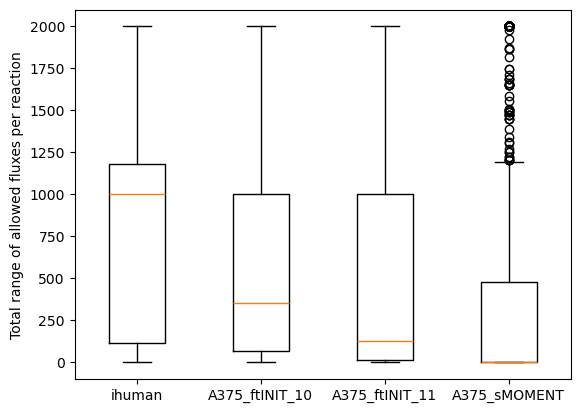

In [ ]:
plt.boxplot([df["variability"] for df in fva_solutions.values()], labels=[name for name in fva_solutions.keys()])

# Adding title and labels
plt.ylabel('Total range of allowed fluxes per reaction')

# Displaying the plot
plt.show()


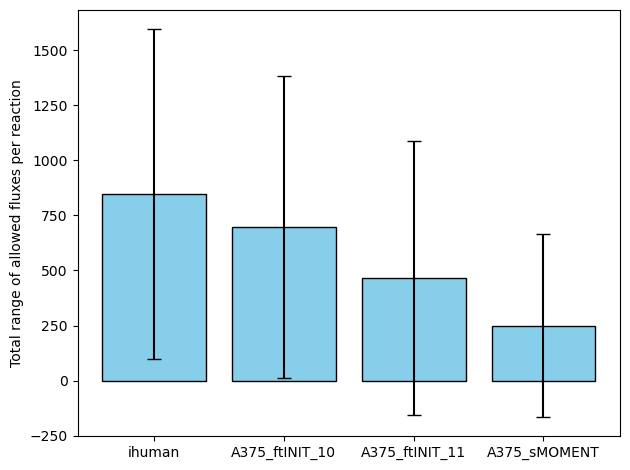

In [160]:
import numpy as np

# Calculate mean and standard deviation for each dataset

means = [np.mean(df["variability"]) for df in fva_solutions.values()]
std_devs = [np.std(df["variability"]) for df in fva_solutions.values()]

# Labels for the datasets
labels = [name for name in fva_solutions.keys()]

# Plotting the bar chart with error bars
x = np.arange(len(labels))  # positions for the bars

plt.bar(x, means, yerr=std_devs, capsize=5, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xticks(x, labels)
plt.ylabel('Total range of allowed fluxes per reaction')

# Show the plot
plt.tight_layout()
plt.show()


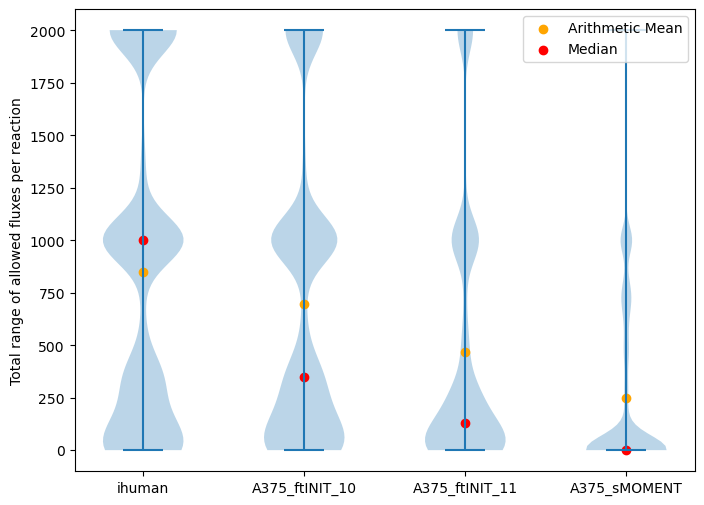

In [155]:
data = [df["variability"] for df in fva_solutions.values()]
labels = [name for name in fva_solutions.keys()]

fig, ax = plt.subplots(figsize=(8, 6))

parts = ax.violinplot(data, showmeans=False, showmedians=False)

# Customizing the plot

# for pc in parts['bodies']:
#     pc.set_facecolor('#1f77b4')
#     pc.set_edgecolor('black')
#     pc.set_alpha(0.7)
# parts['cmedians'].set_color('red')  # Median line

# Adding arithmetic mean markers
means = [np.mean(d) for d in data]
medians = [np.median(d) for d in data]
positions = range(1, len(data) + 1)

ax.scatter(positions, means, color='orange', marker='o', label='Arithmetic Mean')
ax.scatter(positions, medians, color='red', marker='o', label='Median')

# Adding labels and legend
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_ylabel('Total range of allowed fluxes per reaction')
ax.legend()

# Displaying the plot
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_12364\1816902167.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df["relative_variability"] for df in fva_solutions.values()], labels=[name for name in fva_solutions.keys()])


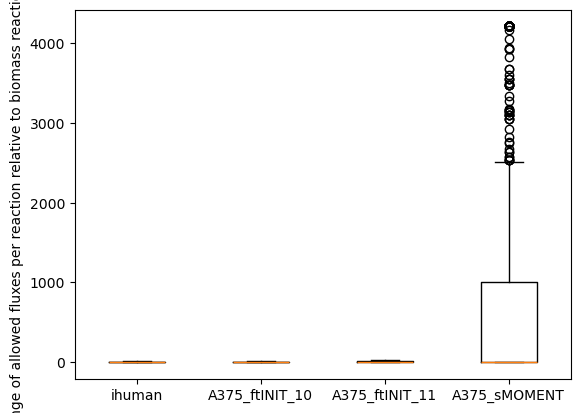

In [19]:
plt.boxplot([df["relative_variability"] for df in fva_solutions.values()], labels=[name for name in fva_solutions.keys()])

# Adding title and labels
plt.ylabel('Range of allowed fluxes per reaction relative to biomass reaction flux')

# Displaying the plot
plt.show()